# ChatGPT prompt:
For each smile that is generated, try to fit a sabr smile. The fit function should be the RMSE between the sabr smile and the generated smile, where each error is the difference of the normal implied volatility between sabr smile and the generated smile, and each error is weighted according to the position of the swaption's strike relatively to the forward: the weight is a linear function that depends on the delta of the call swaption for each relevant strike. The weight should be equal to 1 for delta=0.5, 0.2 for delta=0.25 or delta = 0.75 and equal to 0.1 for delta=0.1 or delta = 0.9 and for other values of delta it should be linearly interpolated from previously given values. Create a plot that displays both the generated smile and the fitted sabr smile.

Fitted alpha=0.001000, rho=-0.000000, nu=0.500000, RMSE=2.566138e-06


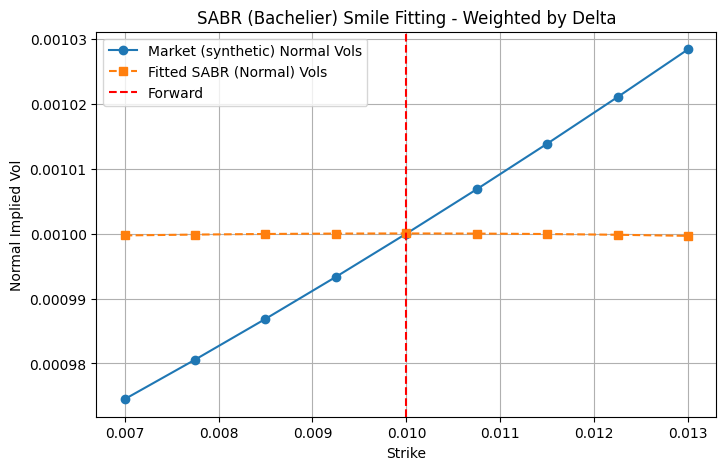

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt, log
from scipy.stats import norm
from scipy.optimize import minimize

##############################################################################
# 1) Bachelier (normal) call price and implied vol/delta
##############################################################################

def bachelier_call_price(forward, strike, vol, expiry):
    """
    Bachelier (normal) model call price (no discounting).
      Call = (F - K) * Phi(d) + sigma * sqrt(T) * phi(d),
    where
      d = (F - K) / (sigma * sqrt(T))
    """
    if vol < 1e-12 or expiry < 1e-12:
        return max(forward - strike, 0.0)

    stdev = vol * sqrt(expiry)
    d = (forward - strike) / stdev
    return (forward - strike)*norm.cdf(d) + stdev*norm.pdf(d)


def bachelier_implied_vol(forward, strike, expiry, price):
    """
    Invert the Bachelier (normal) formula to find the implied vol,
    using a simple numerical approach (Newton or Brent).
    Here, we do a small Brent approach for demonstration.
    """
    if expiry < 1e-12:
        return 0.0
    
    intrinsic = max(forward - strike, 0.0)
    # If price is near 0 or near intrinsic, implied vol may be near 0
    if price <= intrinsic + 1e-14:
        return 1e-12
    
    # Otherwise, solve for sigma in [1e-12..1.0]
    from scipy.optimize import brentq
    
    def f(sigma):
        return bachelier_call_price(forward, strike, sigma, expiry) - price
    
    try:
        vol = brentq(f, 1e-12, 5.0, maxiter=100, disp=False)
        return vol
    except:
        return 1e-12

def bachelier_call_delta(forward, strike, vol, expiry):
    """
    Bachelier (normal) call delta w.r.t. forward = N(d),
    where d = (F-K)/(sigma*sqrt(T)).
    """
    if vol < 1e-12 or expiry < 1e-12:
        return 1.0 if forward > strike else 0.0

    stdev = vol * sqrt(expiry)
    d = (forward - strike)/stdev
    return norm.cdf(d)


##############################################################################
# 2) SABR (Bachelier, beta=0) leading-order expansion for normal implied vol
##############################################################################

import math

def normal_implied_vol_sabr_shifted(F, K, T, alpha, beta, rho, nu, shift=0.0):
    """
    Returns the first-order Hagan 'normal/Bachelier' implied volatility 
    under a shifted SABR model. All inputs are assumed consistent
    (e.g., alpha, nu, etc. are annualized if T is in years).

    Parameters
    ----------
    F : float
        The current forward price (or rate).
    K : float
        The option strike.
    T : float
        Time to maturity (in years).
    alpha : float
        SABR 'alpha' parameter (dimension depends on beta).
    beta : float
        SABR 'beta' parameter in [0, 1].
    rho : float
        SABR 'rho' (correlation) parameter in [-1, 1].
    nu : float
        SABR 'nu' (vol of vol) parameter (>= 0).
    shift : float, optional
        Shift s to apply to F and K, by default 0.0.

    Returns
    -------
    float
        The normal (Bachelier) implied volatility for the shifted SABR model.

    Notes
    -----
    1. This uses the leading-order Hagan expansion for normal implied vol.
    2. If (F+shift) ~ (K+shift), it returns the near-ATM approximation.
    3. For better accuracy away from ATM, or for exotic payoffs, higher-order
       expansions or numerical methods may be needed.
    """

    # 1) Shifted forward and strike
    F_ = F + shift
    K_ = K + shift

    # Edge case: If T == 0 or alpha ~ 0, return 0 to avoid division by zero
    if T <= 0.0 or alpha <= 0.0:
        return 0.0

    # 2) Average forward (some references use geometric average or other forms)
    F_avg = 0.5 * (F_ + K_)

    # If forward ~ strike, use the near-ATM formula
    if abs(F_ - K_) < 1e-12:
        # ATM approximation
        return alpha * (F_avg ** beta)

    # 3) Compute z
    #    Be sure to include sqrt(T)
    z = (nu / alpha) * (F_avg ** (1.0 - beta)) * (F_ - K_) * math.sqrt(T)

    # 4) x(z) function
    A = math.sqrt(1.0 - 2.0 * rho * z + z * z) + (z - rho)
    B = 1.0 - rho
    # Careful with edge cases if A or B ~ 0, but typically they won't be if |rho| < 1
    xz = math.log(A / B)

    # 5) The leading-order normal implied volatility
    #    If z is small, we do x(z)/z -> 1. But let's just do a safe ratio:
    if abs(z) < 1e-12:
        return alpha * (F_avg ** beta)
    else:
        return alpha * (F_avg ** beta) * (xz / z)




##############################################################################
# 3) Delta-to-weight: piecewise linear interpolation
##############################################################################
def delta_to_weight(delta):
    """
    We have anchor points:
      delta=0.1 -> w=0.1
      delta=0.25 -> w=0.2
      delta=0.5 -> w=1.0
      delta=0.75 -> w=0.2
      delta=0.9 -> w=0.1
    For values in-between, linearly interpolate.
    Outside [0.1..0.9], we just clamp to 0.1.
    """
    # Define the knot points
    points = [
        (0.1, 0.0),
        (0.25, 10.0),
        (0.5, 100.0),
        (0.75, 10.0),
        (0.9, 0.0)
    ]
    # Clamp if below 0.1 or above 0.9
    if delta <= 0.1:
        return 0.0
    if delta >= 0.9:
        return 0.0

    # Find where delta fits among the knots
    for i in range(len(points)-1):
        d1, w1 = points[i]
        d2, w2 = points[i+1]
        if d1 <= delta <= d2:
            # linear interpolation
            t = (delta - d1)/(d2 - d1)
            return w1 + t*(w2 - w1)

    # If not found (shouldn't happen), fallback
    return 0.1


##############################################################################
# 4) Weighted RMSE objective function for SABR fit
##############################################################################
def sabr_bachelier_rmse(params, forward, expiry, beta, shift, strikes, mkt_vols):
    """
    params: [alpha, rho, nu, beta]
    Weighted RMSE of difference in normal vol:
       error_i = weight_i * ( vol_sabr_i - vol_mkt_i )^2
    with weight_i from delta. 
    We'll compute each strike's Bachelier delta from the *market vol* 
    (since that's what's given).
    """
    alpha, rho, nu = params
    # Basic domain constraints
    if alpha <= 0 or nu <= 0 or abs(rho) >= 1.0:
        return 1e10  # big penalty

    weights_sum = 0.0
    sq_err_sum = 0.0
    for K, vol_mkt in zip(strikes, mkt_vols):
        # Market delta (using market normal vol)
        delta = bachelier_call_delta(forward, K, vol_mkt, expiry)
        w = delta_to_weight(delta)

        vol_sabr = normal_implied_vol_sabr_shifted(F=forward, K=K, T=expiry, alpha=alpha, beta=beta, rho=rho, nu=nu, shift=shift)

        err = (vol_sabr - vol_mkt)
        sq_err_sum += w * err*err
        weights_sum += w

    if weights_sum < 1e-12:
        return 1e10
    mse = sq_err_sum / weights_sum
    return np.sqrt(mse)


def fit_sabr_bachelier(forward, expiry, beta, shift, strikes, mkt_vols):
    """
    Fit alpha, rho, nu by minimizing the weighted RMSE vs. market normal vols.
    We'll do a local search from some initial guesses.
    """
    # A simple guess: alpha ~ ATM vol, rho ~ 0, nu ~ 0.5
    atm_vol = mkt_vols[len(mkt_vols)//2]  # middle strike as "ATM" approx
    x0 = [atm_vol, 0.0, 0.5]

    # Bounds: alpha>0, nu>0, -0.999<rho<0.999
    bnds = [(1e-7, 1.0), (-0.999, 0.999), (1e-6, 5.0)]

    res = minimize(
        fun=sabr_bachelier_rmse,
        x0=x0,
        args=(forward, expiry, beta, shift, strikes, mkt_vols),
        bounds=bnds,
        method='L-BFGS-B'
    )

    alpha_fit, rho_fit, nu_fit = res.x
    return alpha_fit, rho_fit, nu_fit, res.fun  # also returning final RMSE


##############################################################################
# 5) Example usage: Generate one smile, fit SABR, and plot both
##############################################################################
if __name__ == "__main__":
    # -------------------------
    # (A) Create a synthetic "market" smile
    # -------------------------
    np.random.seed(123)
    forward = 0.01        # 2% forward
    expiry = 1.0          # 2-year to expiry
    strikes = forward * (1.0 + np.linspace(-0.3, 0.3, 9))  # 9 strikes from -30% to +30%

    # Let's pretend we have a "true" SABR param set that generated the market vol
    alpha_true = 0.001   # 50bp in absolute terms
    rho_true   = -0.6
    nu_true    = 1.0

    beta = 0.0
    shift = 0.02

    market_vols = []
    for K in strikes:
        vol_sabr = normal_implied_vol_sabr_shifted(F=forward, K=K, T=expiry, alpha=alpha_true, beta=beta, rho=rho_true, nu=nu_true, shift=shift)
        #vol_sabr_noisy = vol_sabr + 0* vol_sabr * (1.0 + 0.001*np.random.randn())
        market_vols.append(vol_sabr)

    market_vols = np.array(market_vols)

    # -------------------------
    # (B) Fit SABR to these "market" normal vols
    # -------------------------
    alpha_fit, rho_fit, nu_fit, rmse_final = fit_sabr_bachelier(
        forward, expiry, beta, shift, strikes, market_vols
    )

    print(f"Fitted alpha={alpha_fit:.6f}, rho={rho_fit:.6f}, nu={nu_fit:.6f}, RMSE={rmse_final:.6e}")

    # -------------------------
    # (C) Plot both the market smile & the fitted smile
    # -------------------------
    # Evaluate the fitted smile
    fitted_vols = [
        #sabr_bachelier_iv(forward, K, expiry, alpha_fit, rho_fit, nu_fit)
        normal_implied_vol_sabr_shifted(F=forward, K=K, T=expiry, alpha=alpha_fit, beta=beta, rho=rho_fit, nu=nu_fit, shift=shift)
        for K in strikes
    ]

    plt.figure(figsize=(8, 5))
    plt.plot(strikes, market_vols, 'o-', label="Market (synthetic) Normal Vols")
    plt.plot(strikes, fitted_vols, 's--', label="Fitted SABR (Normal) Vols")
    plt.axvline(x=forward, color='r', linestyle='--', label='Forward')
    plt.xlabel("Strike")
    plt.ylabel("Normal Implied Vol")
    plt.title("SABR (Bachelier) Smile Fitting - Weighted by Delta")
    plt.grid(True)
    plt.legend()
    plt.show()


In [61]:
df_real = pd.read_csv("data.csv")

In [64]:
df_gen = pd.read_csv("GeneratedSmiles.csv")
df_gen

,Unnamed: 0,expiry_months,tenor_months,forward,K1,K2,K3,K4,K5,K6,...,K9,vol1,vol2,vol3,vol4,vol5,vol6,vol7,vol8,vol9
0,0,10.932318,65.921210,194.983540,129.762760,145.126800,159.016750,172.132870,189.713520,199.697750,...,248.363950,0.006372,0.005831,0.005371,0.005137,0.005009,0.005017,0.005204,0.005484,0.005955
1,1,3.960615,72.735760,46.011314,28.348510,27.364918,29.675850,33.858930,37.433502,34.754830,...,56.881040,0.006317,0.005685,0.005201,0.004932,0.004780,0.004824,0.005039,0.005164,0.005751
2,2,20.815733,13.527155,13.856184,0.252526,4.160877,-2.088677,1.137896,-6.894731,-2.968855,...,10.607601,0.005533,0.004933,0.004511,0.004222,0.004039,0.004055,0.004208,0.004405,0.004813
3,3,105.604340,153.175220,221.179050,148.531740,165.916320,183.178710,200.698440,218.550300,230.280930,...,278.960450,0.003673,0.003313,0.003035,0.002761,0.002757,0.002716,0.002859,0.003039,0.003279
4,4,109.315180,59.201680,88.674446,59.096470,63.843150,69.038080,74.221970,77.269750,89.742584,...,106.376630,0.003630,0.003281,0.002956,0.002778,0.002708,0.002696,0.002820,0.002944,0.003207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,17.474482,69.802850,168.679300,114.737175,127.559220,138.480550,152.190580,166.707500,175.914370,...,216.540740,0.006121,0.005587,0.005221,0.004899,0.004764,0.004811,0.004970,0.005274,0.005693
9996,9996,5.606863,36.979770,156.730830,109.902030,120.051320,133.486910,146.353840,158.176710,165.223430,...,208.295500,0.006313,0.005765,0.005280,0.005044,0.004825,0.004878,0.005089,0.005374,0.005923
9997,9997,37.862637,67.904106,59.460360,38.531433,42.223860,44.975773,48.154232,50.105354,57.081170,...,75.973915,0.005177,0.004675,0.004258,0.003962,0.003851,0.003856,0.004001,0.004229,0.004508
9998,9998,140.656620,29.121283,30.257193,13.772911,15.393406,12.875831,15.165462,13.312719,23.589067,...,35.939198,0.002931,0.002669,0.002386,0.002182,0.002122,0.002112,0.002120,0.002289,0.002570
